In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Section 1: Setup and Environment***

This initial section handles the necessary imports and sets up the base path for our dataset. We import libraries for data manipulation (pandas), numerical operations (numpy), and file system interaction (os).

In [51]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# --- Configuration ---
# Set the base path to the directory containing the dataset.
# This path points to where the 'train.csv', 'validation.csv', etc., and the 'MI' data folder are located.
# base_path = '/content/mtc-aic3_dataset' # Example for Google Colab
base_path = '/content/drive/MyDrive/aic3/unzipped' # Example for Google Drive

# Define the specific EEG channels to be used for the analysis.
# We focus on central channels C3, CZ, and C4, which are highly relevant for motor imagery tasks.
eeg_channels = ['C3', 'CZ', 'C4']

***Section 2: Data Loading and Filtering***

In this step, we load the metadata from the train.csv and validation.csv files. Since this notebook is dedicated to the Motor Imagery (MI) task, we filter these dataframes to retain only the rows corresponding to 'MI'.

In [53]:
# Load the training and validation metadata files into pandas DataFrames.
train_df = pd.read_csv(f'{base_path}/train.csv')
validation_df = pd.read_csv(f'{base_path}/validation.csv')

# Filter the DataFrames to keep only the entries for the Motor Imagery (MI) task.
# We reset the index to ensure the filtered DataFrame has a clean, contiguous index.
train_mi = train_df[train_df['task'] == 'MI'].reset_index(drop=True)
validation_mi = validation_df[validation_df['task'] == 'MI'].reset_index(drop=True)

# Display the first few rows of the filtered training data to verify the result.
print("Filtered Training Data for MI Task:")
display(train_mi.head())

# Display the first few rows of the filtered validation data.
print("\nFiltered Validation Data for MI Task:")
display(validation_mi.head())

Filtered Training Data for MI Task:


,id,subject_id,task,trial_session,trial,label
0,1,S1,MI,1,1,Left
1,2,S1,MI,1,2,Right
2,3,S1,MI,1,3,Left
3,4,S1,MI,1,4,Left
4,5,S1,MI,1,5,Left



Filtered Validation Data for MI Task:


,id,subject_id,task,trial_session,trial,label
0,4801,S31,MI,1,1,Left
1,4802,S31,MI,1,2,Left
2,4803,S31,MI,1,3,Right
3,4804,S31,MI,1,4,Left
4,4805,S31,MI,1,5,Left


***Plot: Label Distribution in Training Data***

Let's visualize the balance between the 'Left' and 'Right' classes in our training set. An imbalanced dataset might require special handling during model training, such as using class weights.

/tmp/ipython-input-54-503365080.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_mi, palette='viridis')


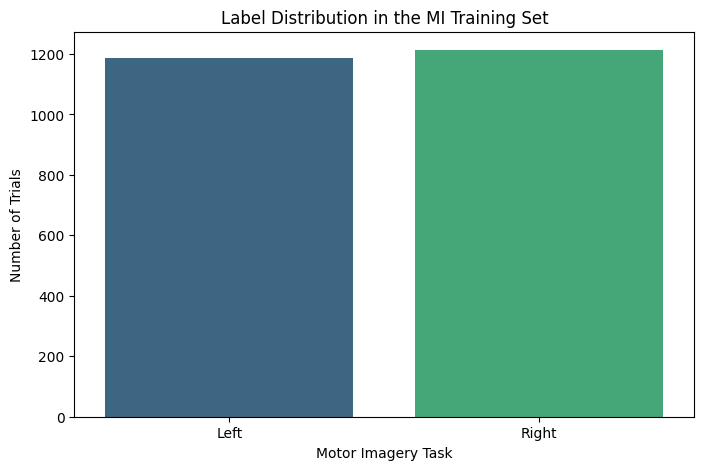

In [54]:
# Visualize the distribution of labels in the training set.
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_mi, palette='viridis')
plt.title('Label Distribution in the MI Training Set')
plt.xlabel('Motor Imagery Task')
plt.ylabel('Number of Trials')
plt.show()

***Section 3: Trial Extraction***

Here, we define a function extract_trials to read the actual EEG signal data from the EEGdata.csv files. The function iterates through our filtered metadata, locates the correct file for each trial, and extracts the corresponding 9-second segment (2250 samples at 250 Hz). We apply this function to build our training, validation, and test datasets.

In [55]:
def extract_trials(df, base_path, is_test=False):
    """
    Extracts EEG trial segments from CSV files based on a metadata DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing trial metadata (subject_id, trial_session, etc.).
        base_path (str): The root directory of the dataset.
        is_test (bool): Flag to indicate if processing the test set (which has no labels).

    Returns:
        tuple: A tuple containing:
            - np.array: The extracted EEG data of shape (n_trials, n_timepoints, n_channels).
            - np.array or None: The corresponding labels (0 for Left, 1 for Right), or None if is_test is True.
    """
    # Initialize lists to store data and labels
    data = []
    labels = []

    # Iterate over each row in the metadata DataFrame with a progress bar
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Determine the dataset split (train, validation, or test) based on the trial ID
        dataset = 'test' if row['id'] >= 4901 else ('validation' if row['id'] >= 4801 else 'train')

        # Get trial-specific information
        subject_id = row['subject_id']
        trial_session = row['trial_session']
        trial_num = int(row['trial'])

        # Construct the full path to the EEG data file
        file_path = os.path.join(base_path, 'MI', dataset, subject_id, str(trial_session), 'EEGdata.csv')
        eeg = pd.read_csv(file_path)

        # Calculate the start and end indices for the trial segment (each trial is 9s * 250Hz = 2250 samples)
        start = (trial_num - 1) * 2250
        end = start + 2250

        # Slice the DataFrame to get the trial segment and select only the specified EEG channels
        eeg_segment = eeg.iloc[start:end][eeg_channels].values  # shape: (2250, n_channels)
        data.append(eeg_segment)

        # If it's not the test set, append the corresponding label (0 for Left, 1 for Right)
        if not is_test:
            labels.append(0 if row['label'] == 'Left' else 1)

    # Convert lists to NumPy arrays
    return np.array(data), (None if is_test else np.array(labels))

# --- Extract Training Data ---
print("Extracting training trials...")
X_train, y_train = extract_trials(train_mi, base_path)

# --- Extract Validation Data ---
print("\nExtracting validation trials...")
X_val, y_val = extract_trials(validation_mi, base_path)

# --- Extract Test Data ---
# Load the test metadata and filter for MI task
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))
test_mi = test_df[test_df['task'] == 'MI'].reset_index(drop=True)
print("\nExtracting test trials...")
X_test, _ = extract_trials(test_mi, base_path, is_test=True)

# Print the shapes of the resulting arrays to confirm the dimensions
print("\n--- Data Shapes ---")
print(f"Train shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Val shape:   {X_val.shape}, Labels: {y_val.shape}")
print(f"Test shape:  {X_test.shape}")

Extracting training trials...


100%|██████████| 2400/2400 [06:04<00:00,  6.58it/s]



Extracting validation trials...


100%|██████████| 50/50 [00:07<00:00,  6.76it/s]



Extracting test trials...


100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


--- Data Shapes ---
Train shape: (2400, 2250, 3), Labels: (2400,)
Val shape:   (50, 2250, 3), Labels: (50,)
Test shape:  (50, 2250, 3)


***Section 4: Data Preprocessing***

Raw EEG signals are often noisy and vary between subjects and trials. This section applies several preprocessing steps to clean and standardize the data, which is crucial for building a robust model.

***4.1 Initial Per-Trial Normalization***

First, we normalize each trial individually. This step centers each trial's signal at zero mean and scales it to a unit standard deviation, helping to mitigate variations in signal amplitude.

In [56]:
def normalize_trials(X):
    """Normalizes each trial to have zero mean and unit standard deviation."""
    # Calculate mean and std deviation across the time axis (axis=1) for each trial
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True)
    # Apply Z-score normalization
    return (X - mean) / std

# Apply normalization to all datasets
X_train = normalize_trials(X_train)
X_val = normalize_trials(X_val)
X_test = normalize_trials(X_test)

print("Applied initial per-trial normalization.")

Applied initial per-trial normalization.


***4.2 Bandpass Filtering***

Motor imagery tasks are known to modulate brain activity in specific frequency bands, primarily the mu (8-13 Hz) and beta (13-30 Hz) bands. We apply a bandpass filter to isolate signals within this 8-30 Hz range, removing irrelevant low-frequency drifts and high-frequency noise.

In [57]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, low=8, high=30, fs=250, order=4):
    """
    Applies a Butterworth bandpass filter to the data.
    """
    # Calculate Nyquist frequency
    nyquist = 0.5 * fs
    # Normalize frequency cutoffs
    low_cut = low / nyquist
    high_cut = high / nyquist
    # Get filter coefficients
    b, a = butter(order, [low_cut, high_cut], btype='band')
    # Apply the filter forward and backward to prevent phase shift
    return filtfilt(b, a, data, axis=0)

# Apply the bandpass filter to each trial in all datasets
print("Applying bandpass filter...")
X_train_filtered = np.array([bandpass_filter(trial) for trial in tqdm(X_train, desc="Filtering Train")])
X_val_filtered = np.array([bandpass_filter(trial) for trial in tqdm(X_val, desc="Filtering Val")])
X_test_filtered = np.array([bandpass_filter(trial) for trial in tqdm(X_test, desc="Filtering Test")])

# For simplicity in the next steps, we overwrite the original variables.
X_train = X_train_filtered
X_val = X_val_filtered
X_test = X_test_filtered

print("Bandpass filtering complete.")

Applying bandpass filter...


Filtering Test: 100%|██████████| 50/50 [00:00<00:00, 599.95it/s]

Bandpass filtering complete.


***Plot: Effect of Filtering***

To understand the impact of our filter, let's plot a single channel from one trial before and after applying the bandpass filter. The filtered signal should appear smoother, with low-frequency drifts and high-frequency noise removed.

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


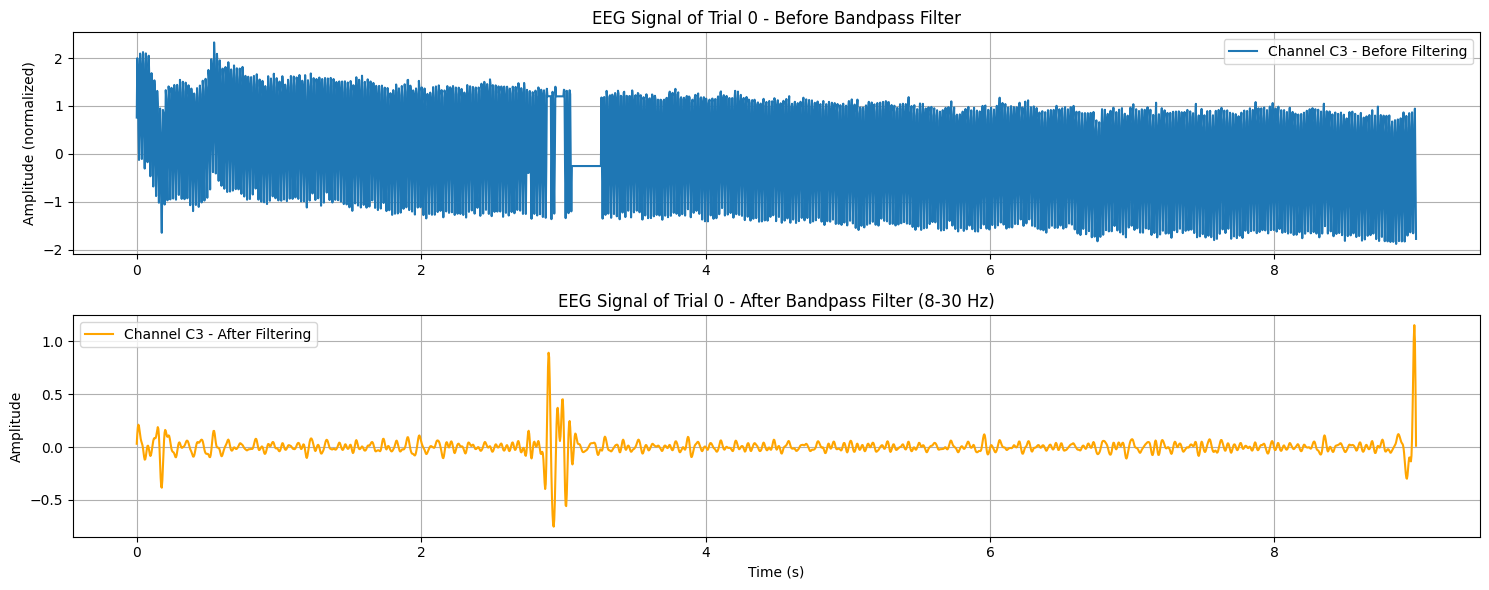

In [58]:
# Select a sample trial and channel to visualize
sample_trial_index = 0
sample_channel_index = 0 # C3 channel
time = np.arange(X_train.shape[1]) / 250.0 # Time in seconds

# Get the raw (but normalized) data from before filtering
# We need to re-run the normalization step on a single trial to get the "before" state
original_trial_raw, _ = extract_trials(train_mi.iloc[[sample_trial_index]], base_path)
original_trial_normalized = normalize_trials(original_trial_raw)[0]


plt.figure(figsize=(15, 6))

# Plot the signal before filtering
plt.subplot(2, 1, 1)
plt.plot(time, original_trial_normalized[:, sample_channel_index], label=f'Channel {eeg_channels[sample_channel_index]} - Before Filtering')
plt.title(f'EEG Signal of Trial {sample_trial_index} - Before Bandpass Filter')
plt.ylabel('Amplitude (normalized)')
plt.legend()
plt.grid(True)

# Plot the signal after filtering
plt.subplot(2, 1, 2)
plt.plot(time, X_train[sample_trial_index, :, sample_channel_index], label=f'Channel {eeg_channels[sample_channel_index]} - After Filtering', color='orange')
plt.title(f'EEG Signal of Trial {sample_trial_index} - After Bandpass Filter (8-30 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

***4.3 Subject-wise Normalization***

Different subjects can have vastly different baseline EEG signal characteristics. To account for this, we perform a second normalization step, this time on a per-subject basis. We calculate the mean and standard deviation across all trials belonging to a single subject and use these statistics to normalize that subject's data.

In [59]:
from collections import defaultdict

def group_trials_by_subject(df):
    """Groups trial indices by their subject_id."""
    subject_trials = defaultdict(list)
    for i, row in df.iterrows():
        subject_trials[row['subject_id']].append(i)
    return subject_trials

def subjectwise_normalize(X, df):
    """
    Normalizes EEG data on a per-subject basis.
    """
    # Create a map from subject_id to their trial indices
    subject_map = group_trials_by_subject(df)
    # Create an empty array to store the normalized data
    X_norm = np.empty_like(X)

    # Iterate over each subject and their corresponding trial indices
    for subject_id, indices in subject_map.items():
        # Get all data for the current subject
        subject_data = X[indices]  # Shape: (n_trials, n_time, n_channels)

        # Flatten the data across trials and time to calculate statistics per channel
        all_data_flat = subject_data.reshape(-1, X.shape[2])  # Shape: (n_trials * time, n_channels)

        # Calculate mean and std for each channel across all of the subject's data
        mean = all_data_flat.mean(axis=0)
        std = all_data_flat.std(axis=0)

        # Normalize the subject's data and place it back in the main array
        X_norm[indices] = (subject_data - mean) / std

    return X_norm

# Apply subject-wise normalization to all datasets
print("Applying subject-wise normalization...")
X_train = subjectwise_normalize(X_train, train_mi)
X_val = subjectwise_normalize(X_val, validation_mi)
X_test = subjectwise_normalize(X_test, test_mi)

print("Subject-wise normalization complete.")

Applying subject-wise normalization...
Subject-wise normalization complete.


***Section 5: Feature Engineering***

The preprocessed time-series data is high-dimensional. We now extract meaningful, lower-dimensional features that our machine learning model can use to discriminate between 'Left' and 'Right' motor imagery. We will use two powerful techniques: Common Spatial Patterns (CSP) and Power Spectral Density (PSD).

***5.1 Common Spatial Patterns (CSP)***

CSP is a technique that designs spatial filters to maximize the variance for one class while simultaneously minimizing it for the other. It's highly effective for discriminating between motor imagery states.

In [60]:
# Install the MNE-Python library if it's not already installed.
!pip install -q mne

In [61]:
from mne.decoding import CSP

# Reshape data for CSP: from (n_trials, n_timepoints, n_channels) to (n_trials, n_channels, n_timepoints)
X_train_csp_input = X_train.transpose(0, 2, 1)
X_val_csp_input = X_val.transpose(0, 2, 1)
X_test_csp_input = X_test.transpose(0, 2, 1)

# Initialize the CSP algorithm. We'll extract 4 components.
# These components represent spatial filters that best separate the two classes.
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Fit CSP on the training data and transform it to get CSP features
print("Fitting and transforming data with CSP...")
X_train_csp = csp.fit_transform(X_train_csp_input, y_train)

# Use the fitted CSP to transform the validation and test data
X_val_csp = csp.transform(X_val_csp_input)
X_test_csp = csp.transform(X_test_csp_input)

print(f"Shape of CSP features for training data: {X_train_csp.shape}")

Fitting and transforming data with CSP...
Computing rank from data with rank=None
    Using tolerance 2.5 (2.2e-16 eps * 3 dim * 3.8e+15  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Shape of CSP features for training data: (2400, 3)


***5.2 Power Spectral Density (PSD) Features***
PSD measures how the power of a signal is distributed over different frequencies. We calculate the power in five common EEG bands (Delta, Theta, Alpha, Beta, Gamma) for each channel. This gives us frequency-based features that complement the spatial features from CSP.

In [62]:
from scipy.signal import welch

def compute_psd(trial, fs=250, bands=[(0.5,4), (4,8), (8,13), (13,30), (30,50)]):
    """
    Computes Power Spectral Density (PSD) features for a single trial.
    """
    features = []
    # Iterate over each channel in the trial
    for ch in range(trial.shape[1]):
        # Use Welch's method to compute the power spectrum
        f, Pxx = welch(trial[:, ch], fs=fs, nperseg=256)
        # For each frequency band, calculate the total power (area under the curve)
        for band in bands:
            fmin, fmax = band
            band_power = np.trapz(Pxx[(f >= fmin) & (f <= fmax)], f[(f >= fmin) & (f <= fmax)])
            features.append(band_power)
    return features

def extract_psd_features(X):
    """Applies PSD feature extraction to all trials in a dataset."""
    all_features = []
    for trial in tqdm(X, desc="Extracting PSD Features"):
        feat = compute_psd(trial)
        all_features.append(feat)
    return np.array(all_features)

# Extract PSD features for all datasets
X_train_psd = extract_psd_features(X_train)
X_val_psd = extract_psd_features(X_val)
X_test_psd = extract_psd_features(X_test)

print(f"Shape of PSD features for training data: {X_train_psd.shape}")

Extracting PSD Features:   0%|          | 0/2400 [00:00<?, ?it/s]/tmp/ipython-input-62-3685399769.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(Pxx[(f >= fmin) & (f <= fmax)], f[(f >= fmin) & (f <= fmax)])
Extracting PSD Features:  10%|▉         | 233/2400 [00:00<00:05, 371.48it/s]/tmp/ipython-input-62-3685399769.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(Pxx[(f >= fmin) & (f <= fmax)], f[(f >= fmin) & (f <= fmax)])
Extracting PSD Features:  40%|███▉      | 958/2400 [00:04<00:10, 138.78it/s]/tmp/ipython-input-62-3685399769.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(Pxx[(f >= fmin) & (f <= fmax)], f[(f >= fmin) & (f <= fmax)

Shape of PSD features for training data: (2400, 15)


***5.3 Feature Combination***

Finally, we combine the features from CSP and PSD into a single feature vector for each trial. This unified feature set will be used to train our classifier.

In [63]:
# Horizontally stack the CSP and PSD feature arrays
X_train_csp_psd = np.hstack([X_train_csp, X_train_psd])
X_val_csp_psd = np.hstack([X_val_csp, X_val_psd])
X_test_csp_psd = np.hstack([X_test_csp, X_test_psd])

print(f"Shape of combined (CSP+PSD) training features: {X_train_csp_psd.shape}")
print(f"Shape of combined (CSP+PSD) validation features: {X_val_csp_psd.shape}")

Shape of combined (CSP+PSD) training features: (2400, 18)
Shape of combined (CSP+PSD) validation features: (50, 18)


***Section 6: Model Training and Evaluation***

With our features engineered, we can now train a classification model. We'll evaluate two powerful gradient boosting models, LightGBM and CatBoost, and select the best one for our final predictions.

***6.1 LightGBM Model (for comparison)***

LightGBM is a fast and efficient gradient boosting framework. We'll train it as a baseline.

In [64]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Initialize the LightGBM classifier with selected hyperparameters
clf = lgb.LGBMClassifier(
    n_estimators=70,
    learning_rate=0.05,
    max_depth=5,
    class_weight='balanced',  # Helps with any class imbalance
    random_state=42
)

# Train the model on the combined training features
print("Training LightGBM model...")
clf.fit(X_train_csp_psd, y_train)

# Make predictions on the training and validation sets
y_train_pred_lgb = clf.predict(X_train_csp_psd)
y_val_pred_lgb = clf.predict(X_val_csp_psd)

# Evaluate the model's performance
print("\n--- LightGBM Model Performance ---")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_lgb):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_lgb):.4f}")
print("\nValidation Report:")
print(classification_report(y_val, y_val_pred_lgb, target_names=["Left", "Right"]))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training LightGBM model...
[LightGBM] [Info] Number of positive: 1213, number of negative: 1187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


***6.2 CatBoost Model (Final Model)***

CatBoost is another robust gradient boosting library, known for its good performance without extensive hyperparameter tuning. We will use this as our final model.

In [65]:
# Install catboost if not already installed
!pip install -q catboost

In [66]:
from catboost import CatBoostClassifier

# Initialize the CatBoost classifier
cat_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.05,
    depth=5,
    l2_leaf_reg=3.0,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=False,  # Suppress training output
    class_weights=[1.1, 0.9] # Assign slightly more weight to the minority class if needed
)

# Train the CatBoost model
print("Training CatBoost model...")
cat_clf.fit(X_train_csp_psd, y_train)

# Make predictions on the training and validation sets
y_train_pred = cat_clf.predict(X_train_csp_psd)
y_val_pred = cat_clf.predict(X_val_csp_psd)

# Evaluate the model's performance
print("\n--- CatBoost Model Performance ---")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

# Display a detailed classification report for the validation set
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Left", "Right"]))

Training CatBoost model...

--- CatBoost Model Performance ---
Training Accuracy: 0.6058
Validation Accuracy: 0.6000

Validation Classification Report:
              precision    recall  f1-score   support

        Left       0.61      0.82      0.70        28
       Right       0.58      0.32      0.41        22

    accuracy                           0.60        50
   macro avg       0.59      0.57      0.55        50
weighted avg       0.60      0.60      0.57        50



***Section 7: Results Visualization***

To better understand the performance of our final CatBoost model, we visualize its predictions on the validation set.
Plot: Label Distribution in Validation Set
First, let's confirm the distribution of the true labels in the validat

/tmp/ipython-input-67-1038978240.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_val_named, palette='pastel')


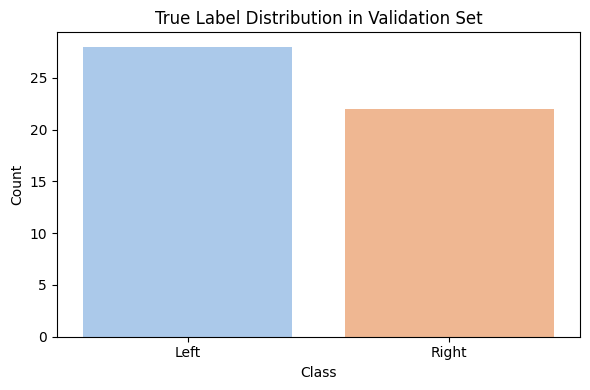

In [67]:
# Map numeric labels back to names for plotting
label_map = {0: 'Left', 1: 'Right'}
y_val_named = pd.Series(y_val).map(label_map)

# Plot the count of each class in the validation set
plt.figure(figsize=(6, 4))
sns.countplot(x=y_val_named, palette='pastel')
plt.title('True Label Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

***Plot: Confusion Matrix***

A confusion matrix provides a detailed look at the model's performance, showing correct predictions versus incorrect ones (false positives and false negatives).

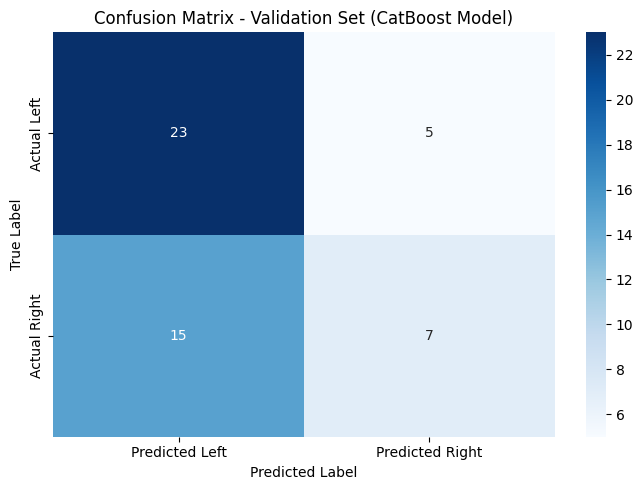

In [68]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(7, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted Left", "Predicted Right"],
            yticklabels=["Actual Left", "Actual Right"])
plt.title("Confusion Matrix - Validation Set (CatBoost Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

***Section 8: Test Set Prediction and Submission***

Now we apply the full pipeline—CSP transformation, PSD feature extraction, and feature combination—to the test data. We then use our trained CatBoost model to predict the labels and generate the final submission file.

In [69]:
# 1. Use the fitted CSP model to transform the test data
# Note: X_test_csp was already computed in Section 5.1

# 2. Extract PSD features from the test data
# Note: X_test_psd was already computed in Section 5.2

# 3. Combine the CSP and PSD features for the test set
# Note: X_test_csp_psd was already computed in Section 5.3

# 4. Use the trained CatBoost model to predict labels for the test set
print("Predicting labels for the test set...")
y_test_pred = cat_clf.predict(X_test_csp_psd).flatten() # Flatten to ensure 1D array

# 5. Map the numeric predictions (0, 1) back to string labels ('Left', 'Right')
label_map = {0: 'Left', 1: 'Right'}
y_test_pred_labels = [label_map[label] for label in y_test_pred]

# 6. Create a submission DataFrame in the required format
submission_df = pd.DataFrame({
    'id': test_mi['id'].values,
    'label': y_test_pred_labels
})

# 7. Save the DataFrame to a CSV file
submission_filename = 'CSP_PSD_CatBoost_submission.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\nSubmission file saved as '{submission_filename}'")
display(submission_df.head())

Predicting labels for the test set...

Submission file saved as 'CSP_PSD_CatBoost_submission.csv'


,id,label
0,4901,Left
1,4902,Left
2,4903,Right
3,4904,Left
4,4905,Right


***Section 9: Model Saving***

Finally, we save our trained CatBoost model to a file using joblib. This allows us to load and use the model in the future without needing to repeat the entire training process.

In [70]:
import joblib

# Define the filename for the saved model
model_filename = 'catboost_mi_model.pkl'

# Save the trained classifier object to a file
joblib.dump(cat_clf, model_filename)

print(f"Trained CatBoost model saved to '{model_filename}'")

Trained CatBoost model saved to 'catboost_mi_model.pkl'


In [71]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize CatBoost model
cat_clf = CatBoostClassifier(
    iterations=85,
    learning_rate=0.05,
    depth=5,
    l2_leaf_reg=3.0,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=False,
    class_weights=[1.1, 0.9]
)

# Fit the model
cat_clf.fit(X_train_csp_psd, y_train)

# Predict
y_train_pred = cat_clf.predict(X_train_csp_psd)
y_val_pred = cat_clf.predict(X_val_csp_psd)

In [72]:
# Accuracy
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

# Classification Report
print("\n Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Left", "Right"]))

Training Accuracy: 0.5950
Validation Accuracy: 0.6000

 Validation Classification Report:
              precision    recall  f1-score   support

        Left       0.61      0.82      0.70        28
       Right       0.58      0.32      0.41        22

    accuracy                           0.60        50
   macro avg       0.59      0.57      0.55        50
weighted avg       0.60      0.60      0.57        50



In [73]:
# --- IN YOUR TRAINING NOTEBOOK ---

import joblib
from collections import defaultdict

# --- 1. Save the Final Trained CatBoost Model ---
model_filename = 'catboost_mi_model.pkl'
joblib.dump(cat_clf, model_filename)
print(f"Trained CatBoost model saved to '{model_filename}'")

# --- 2. Save the Fitted CSP Transformer ---
# The 'csp' object was fitted on the training data. We need it for the test set.
csp_filename = 'csp_mi_transformer.pkl'
joblib.dump(csp, csp_filename)
print(f"Fitted CSP transformer saved to '{csp_filename}'")

# --- 3. Calculate and Save Subject-wise Normalization Statistics ---
# We need these stats to apply the same transformation to the test data.

def get_subject_stats(X, df):
    """Calculates mean/std for each subject and a global fallback."""
    subject_map = defaultdict(list)
    for i, row in df.iterrows():
        subject_map[row['subject_id']].append(i)

    stats = {'subjects': {}}
    all_subject_data_flat = []

    # Calculate per-subject stats
    for subject_id, indices in subject_map.items():
        subject_data = X[indices]
        all_data_flat = subject_data.reshape(-1, X.shape[2])
        stats['subjects'][subject_id] = {
            'mean': all_data_flat.mean(axis=0),
            'std': all_data_flat.std(axis=0)
        }
        all_subject_data_flat.append(all_data_flat)

    # Calculate global stats as a fallback for unseen subjects
    global_data = np.vstack(all_subject_data_flat)
    stats['global'] = {
        'mean': global_data.mean(axis=0),
        'std': global_data.std(axis=0)
    }
    return stats

# NOTE: Use the *filtered but not yet subject-normalized* training data to calculate stats.
# Re-create this data if you overwrote the variable.
X_train_before_subject_norm = np.array([bandpass_filter(trial) for trial in normalize_trials(extract_trials(train_mi, base_path)[0])])
subject_stats = get_subject_stats(X_train_before_subject_norm, train_mi)

stats_filename = 'mi_subject_stats.pkl'
joblib.dump(subject_stats, stats_filename)
print(f"Subject normalization stats saved to '{stats_filename}'")

Trained CatBoost model saved to 'catboost_mi_model.pkl'
Fitted CSP transformer saved to 'csp_mi_transformer.pkl'


100%|██████████| 2400/2400 [05:47<00:00,  6.91it/s]


Subject normalization stats saved to 'mi_subject_stats.pkl'
